In [31]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from math import *
from numpy import linalg as LA
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from DiTree import *

In [32]:
path = 'alg1-star-plot'
graph_prefix = 'star'
save_plots = False

REVISED VERSION:

DIRECTED CASE (alg 1):
- 3 different settings for (a,b)
- 2 different settings for graph: star (10 nodes, agents 0-4 nonzero), random graph (100 nodes, agents 0-94 nonzero)
- plots: current plots + additional upper level objective values


for star graph: R matrix == every node point toward center, C matrix == center to every node

UNDIRECTED STOCHASTIC CASE (alg 2):
- to generate data, treat b_i as a random variable (see paper), sample from dataset U(1,10) (uniform 1-10)
- also change plots: need expectation
- expectation of b_i = 5.5, for plots can use a deterministic function with 5.5 replaced everywhere

- run each for 5 samplepaths (tweak as needed for good plots) --- plot with confidence intervals
p 2 different settings for graph: petersen (10 nodes) and random (100 nodes)


- Total: 9 plots for each graph, 4 figures, save as 36 PDFs

CHANGELOG:
1. moreau smoothing parameter changed from 0.1 to 0.01 to guarantee convergence of lower level

In [ ]:
# Setting up data
# ---------------

np.random.seed(1)
moreau = 0.1
N = 10

"""
returns:
a_values (vector size N)
C matrix (matrix size NxN)
upper box constraints (vector size N)
lower box constraints (vector size N)
"""
# a_i ~U[1,10] for i = 0..14, and a_i = 0 for i = 15..19
# more generally, a_i = 0 for i = (n-5)..(n-1)
#a_values = np.random.uniform(low=1, high=10, size=N)
#a_values[-5:] = 0
"""
new version:
a_values = diag(C matrix) # after evaluating matrix C
"""

# b_i ~U[1,10] for all i = 0..(n-1)
b_values = np.random.uniform(low=1, high=10, size=N)

# C is a positive definite matrix
A = np.random.randn(N, N//2)
C = A.dot(A.T)                           # C_bar in the paper
a_values = np.diag(C)
reg_param = 1e-5
reg_weight = reg_param + np.max([0, -np.min(LA.eigvals(C - 0.5 * np.diagflat(a_values)))])

upper_box_constraints = np.random.uniform(low=5, high=10, size=N)
lower_box_constraints = np.zeros((N))

In [34]:
# Graph generation
# ----------------

"""
Generates two directed star graph with N nodes, including central node.
The first star graph has only directed edges from the central node to all edge nodes.
The second star graph has only directed edges from the edge nodes to the central node.
"""
def star_graph(N):
    G_R, G_C = nx.DiGraph(), nx.DiGraph()
    G_R.add_nodes_from(range(N))
    G_C.add_nodes_from(range(N))
    for i in range(1,N):
        G_R.add_edge(0,i)
        G_C.add_edge(i,0)
    W_R = nx.to_numpy_array(G_R) + np.diag(np.ones(N))
    W_C = nx.to_numpy_array(G_C) + np.diag(np.ones(N))
    for i in range(N):
        W_R[0,i] = W_R[i,i] = 1/N
        W_R[i,0] = (N-1)/N
        W_C[i,0] = W_C[i,i] = 1/N
        W_C[0,i] = (N-1)/N
    W_R[0,0] = W_C[0,0] = 0.1
    return G_R, W_R, G_C, W_C

In [35]:
gr, wr, gc, wc = star_graph(10)
print(wr)

print(wc)

[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.9 0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.9 0.  0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.9 0.  0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.9 0.  0.  0.  0.1 0.  0.  0.  0.  0. ]
 [0.9 0.  0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.9 0.  0.  0.  0.  0.  0.1 0.  0.  0. ]
 [0.9 0.  0.  0.  0.  0.  0.  0.1 0.  0. ]
 [0.9 0.  0.  0.  0.  0.  0.  0.  0.1 0. ]
 [0.9 0.  0.  0.  0.  0.  0.  0.  0.  0.1]]
[[0.1 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9]
 [0.1 0.1 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.1 0.  0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.  0.1 0.  0.  0.  0.  0.  0. ]
 [0.1 0.  0.  0.  0.1 0.  0.  0.  0.  0. ]
 [0.1 0.  0.  0.  0.  0.1 0.  0.  0.  0. ]
 [0.1 0.  0.  0.  0.  0.  0.1 0.  0.  0. ]
 [0.1 0.  0.  0.  0.  0.  0.  0.1 0.  0. ]
 [0.1 0.  0.  0.  0.  0.  0.  0.  0.1 0. ]
 [0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.1]]


In [36]:
# Mappings and Gradient definitions
# ---------------------------------

"""
input: x is a vector size N
output: a scalar
"""
def f_fun(x):
    out = 0
    for i in range(len(x)):
        out += f_i(x,i)
    return out + 0.5*reg_weight*LA.norm(x)**2

"""
input: x is a vector size N
output: a scalar
"""
def f_i(x, i):
    x_i = x[i]
    return 0.5*a_values[i]*x_i**2 + b_values[i]*x_i \
               + (np.dot(C[i], x) - C[i,i]*x_i)*x_i \
               + LA.norm(x_i - np.clip(x_i, lower_box_constraints[i], upper_box_constraints[i]))**2 / (2*moreau)

"""
input: x is a vector size N
output: returns vector size N
"""
def grad_f_i(x, i):
    x_i = x[i]
    grad_f_i = C[i]*x_i
    grad_f_i[i] = a_values[i]*x_i + b_values[i] \
                    + (np.dot(C[i], x) - C[i,i]*x_i) \
                    + (x_i - np.clip(x_i, lower_box_constraints[i], upper_box_constraints[i]))/moreau
    return grad_f_i

"""
input: X_mat is a matrix NxN, X_mat[i] is the ith agent (player) vector
output: returns matrix A size N.N, where A[i] = ∇f_i(x_i) (bolded gradient f)
"""
def grad_f(X_mat):
    grad_f = np.zeros((N,N))
    for i in range(N):
        grad_f[i] = grad_f_i(X_mat[i], i)
    return grad_f + reg_weight*X_mat

def grad_f_IRG(x_vec):
    grad_f = np.zeros(N, dtype=np.complex128)
    for i in range(N):
        grad_f += grad_f_i(x_vec, i)
    return grad_f + reg_weight*x_vec

"""
input: x is a vector size N
output: returns sparse vector size N, where only the ith element is nonzero
"""
def F_i(x, i):
    F_i = np.zeros(N)
    x_i = x[i]
    F_i[i] = a_values[i]*x_i + b_values[i] \
               + (np.dot(C[i], x) - C[i,i]*x_i) \
               + (x_i - np.clip(x_i, lower_box_constraints[i], upper_box_constraints[i]))/moreau
    return F_i

"""
input: X_mat is a matrix NxN, X_mat[i] is the ith agent (player) vector
output: returns matrix size NxN: this is the bold F in the algorithm, not the unbolded F in the problem formulation
"""
def F_fun(X_mat):
    F = np.zeros((N,N))
    for i in range(N):
        F[i] = F_i(X_mat[i], i)
    return F

"""
input: x_avg_vec is a vector size N
output: returns vector size N: this is the unbolded F in the problem formulation
"""
def F_sum(x_avg_vec):
    F_vec = np.zeros(N)
    for i in range(N):
        F_vec += F_i(x_avg_vec, i)
    return F_vec

In [37]:
def DIR_DSGT(
    max_iter: int,
    epoch_size: int,
    X_0: np.ndarray,
    R_matrix: np.ndarray,
    C_matrix: np.ndarray,
    a_update_param,
    b_update_param,
    Gamma):

    m,_ = X_0.shape
    lower_vals = np.zeros(epoch_size + 1)
    delta_x_vals = np.zeros(epoch_size + 1)
    upper_vals = np.zeros(epoch_size + 1)
    consensus_vals = np.zeros(epoch_size + 1)
    X_next = X_0

    u = LA.eig(R_matrix.T)[1][0]
    u = u / np.mean(u) # try wrapping in np.real() if doesn't work right

    # update rules for stepsize (gamma_k) and regularization parameter (lambda_k)
    stepsize_rule = lambda x : 1e-3 / ((x+Gamma)**a_update_param)      # gamma_k
    regularizer_rule = lambda x : 1e-3 / ((x+Gamma)**b_update_param)    # lambda_k
    
    F_mat_next = F_fun(X_next)
    grad_f_mat_next = grad_f(X_next)
    
    # Y_0 is initialized to the gradient of the base function
    Y_next = F_mat_next + regularizer_rule(0) * grad_f(X_0)
    epoch_idx = 0
    
    for k in range(1, max_iter + 2):
        # updates:
        stepsize = stepsize_rule(k) * np.eye(m)
        lambda_k_now, lambda_k_next = regularizer_rule(k), regularizer_rule(k+1)
        X_now, Y_now = X_next, Y_next
        F_mat_now, grad_f_mat_now = F_mat_next, grad_f_mat_next

        # update X:    
        X_next = R_matrix.dot(X_now - np.dot(stepsize, Y_now))
        
        # update gradients:
        F_mat_next = F_fun(X_next)
        grad_f_mat_next = grad_f(X_next)
        
        # update Y tracker:
        Y_next = C_matrix.dot(Y_now) + (F_mat_next - F_mat_now) + (lambda_k_next * grad_f_mat_next - lambda_k_now * grad_f_mat_now)
        
        if max_iter == 0 or ((k-1) % np.ceil(max_iter/epoch_size)) == 0:
            x_ave_now = np.dot(u, X_now) / m
            x_ave_next = np.dot(u, X_next) / m

            lower_vals[epoch_idx] = LA.norm(F_sum(x_ave_now))
            delta_x_vals[epoch_idx] = LA.norm(x_ave_next-x_ave_now)
            upper_vals[epoch_idx] = f_fun(x_ave_now)
            consensus_vals[epoch_idx] = LA.norm(X_now - np.dot(np.ones((m,1)), x_ave_now.reshape(1,m)))
            epoch_idx += 1

    return lower_vals, delta_x_vals, upper_vals, consensus_vals

In [38]:
def IRG(
    max_iter: int,
    epoch_size: int,
    X_0: np.ndarray,
    a_update_param,
    b_update_param,
    Gamma):

    m = len(X_0)
    lower_vals = np.zeros(epoch_size + 1)
    delta_x_vals = np.zeros(epoch_size + 1)
    upper_vals = np.zeros(epoch_size + 1)
    consensus_vals = np.zeros(epoch_size + 1)
    X_next = X_0

    # update rules for stepsize (gamma_k) and regularization parameter (lambda_k)
    stepsize_rule = lambda x : 1e-3 / ((x+Gamma)**a_update_param)      # gamma_k
    regularizer_rule = lambda x : 1e-3 / ((x+Gamma)**b_update_param)    # lambda_k
    
    epoch_idx = 0
    
    for k in range(1, max_iter + 2):
        # updates:
        stepsize = stepsize_rule(k)
        X_now = X_next
        X_next = X_now - stepsize * (F_sum(X_now) + regularizer_rule(k) * grad_f_IRG(X_now))
        
        if max_iter == 0 or ((k-1) % np.ceil(max_iter/epoch_size)) == 0:
            lower_vals[epoch_idx] = LA.norm(F_sum(X_now))
            delta_x_vals[epoch_idx] = LA.norm(X_next-X_now)
            upper_vals[epoch_idx] = f_fun(X_now)
            consensus_vals[epoch_idx] = LA.norm(X_now - np.dot(np.ones((m,1)), X_now.reshape(1,m)))
            epoch_idx += 1
    
    return lower_vals, delta_x_vals, upper_vals, consensus_vals

In [39]:
a_b_params = [(0.5, 0.3), (0.6, 0.25), (0.675, 0.2)]
runcolor  = { (0.5, 0.3): 'r', (0.6, 0.25): 'g', (0.675, 0.2): 'b' }
runmarker = { (0.5, 0.3): 'o', (0.6, 0.25): 'v', (0.675, 0.2): 's' }

Gamma = 10

max_iter = 10_000
epoch_size = 10
X_0 = np.random.normal(2, 0.2, size=(N,N))

G_R, R_matrix, G_C, C_matrix = star_graph(N)

lower_vals_results = {}
delta_x_vals_results = {}
upper_vals_results = {}
consensus_vals_results = {}

for (a,b) in tqdm(a_b_params):
    lower_vals, delta_x_vals, upper_vals, consensus_vals = DIR_DSGT(max_iter, epoch_size, X_0, R_matrix, C_matrix, a, b, Gamma)
    lower_vals_results[(a,b)] = lower_vals
    delta_x_vals_results[(a,b)] = delta_x_vals
    upper_vals_results[(a,b)] = upper_vals
    consensus_vals_results[(a,b)] = consensus_vals

  0%|          | 0/3 [00:00<?, ?it/s]

In [40]:
# IRG for comparison
u = LA.eig(R_matrix.T)[1][0] if R_matrix.ndim > 1 else 1
u = u / np.mean(u) # try wrapping in np.real() if doesn't work right
x_0_IRG = np.dot(u, X_0) / N

IRG_lower_vals_results = {}
IRG_delta_x_vals_results = {}
IRG_upper_vals_results = {}
IRG_consensus_vals_results = {}

for (a,b) in tqdm(a_b_params):
    lower_vals, delta_x_vals, upper_vals, consensus_vals = IRG(max_iter, epoch_size, x_0_IRG, a, b, Gamma)
    IRG_lower_vals_results[(a,b)] = lower_vals
    IRG_delta_x_vals_results[(a,b)] = delta_x_vals
    IRG_upper_vals_results[(a,b)] = upper_vals
    IRG_consensus_vals_results[(a,b)] = consensus_vals

  0%|          | 0/3 [00:00<?, ?it/s]

/var/folders/4v/jj1w51cj0y72_jqc08dqywb40000gp/T/ipykernel_82953/1826768716.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  F_i[i] = a_values[i]*x_i + b_values[i] \
/var/folders/4v/jj1w51cj0y72_jqc08dqywb40000gp/T/ipykernel_82953/1956103587.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  upper_vals[epoch_idx] = f_fun(X_now)


(a,b) == 
(0.5, 0.3)
(0.6, 0.25)
(0.675, 0.2)


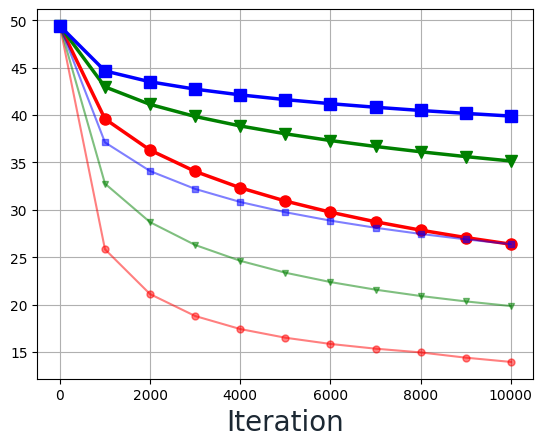

In [41]:
# LOWER LEVEL OBJECTIVE PLOTS

x_ax = list(range(0,max_iter+1,ceil(max_iter/epoch_size)))
fig0, ax0 = plt.subplots()

print('(a,b) == ')

for key in a_b_params:
    print(key)
    ax0.plot(x_ax, lower_vals_results[key], lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
    ax0.plot(x_ax, IRG_lower_vals_results[key], lw=1.5, marker=runmarker[key], markersize=5, color=runcolor[key], alpha=0.5)

ax0.grid(True)
ax0.set_xlabel('Iteration', color='#1C2833',fontsize=20)

if save_plots:
    fig0.savefig(f"./{path}/{graph_prefix}_lower_level.pdf", dpi=600, format="pdf", pad_inches=0.01)

plt.show()

(a,b) == 
(0.5, 0.3)
(0.6, 0.25)
(0.675, 0.2)


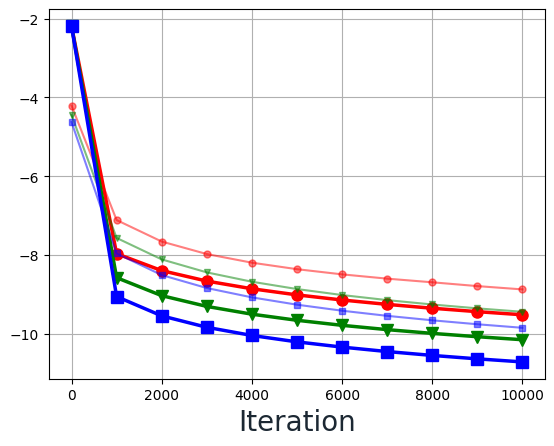

In [42]:
# CHANGE IN STEP (UPPER LEVEL) PLOTS

fig1, ax1 = plt.subplots()

print('(a,b) == ')

for key in a_b_params:
    print(key)
    ax1.plot(x_ax, np.log(delta_x_vals_results[key]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
    ax1.plot(x_ax, np.log(IRG_delta_x_vals_results[key]), lw=1.5, marker=runmarker[key], markersize=5, color=runcolor[key], alpha=0.5)

ax1.grid(True)
ax1.set_xlabel('Iteration', color='#1C2833',fontsize=20)

if save_plots:
    fig1.savefig(f"./{path}/{graph_prefix}_upper_level.pdf", dpi=600, format="pdf", pad_inches=0.01)

plt.show()

(a,b) == 
(0.5, 0.3)
(0.6, 0.25)
(0.675, 0.2)


/var/folders/4v/jj1w51cj0y72_jqc08dqywb40000gp/T/ipykernel_82953/2317084110.py:10: RuntimeWarning: divide by zero encountered in log
  ax3.plot(x_ax, np.log(IRG_consensus_vals_results[key]), lw=1.5, marker=runmarker[key], markersize=5, color=runcolor[key], alpha=0.5)


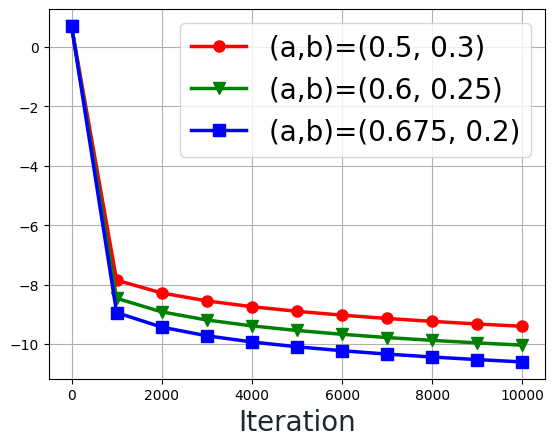

In [43]:
# CONSENSUS ERROR PLOTS

fig3, ax3 = plt.subplots()

print('(a,b) == ')

for key in a_b_params:
    print(key)
    ax3.plot(x_ax, np.log(consensus_vals_results[key]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
    ax3.plot(x_ax, np.log(IRG_consensus_vals_results[key]), lw=1.5, marker=runmarker[key], markersize=5, color=runcolor[key], alpha=0.5)

ax3.grid(True)
ax3.set_xlabel('Iteration', color='#1C2833',fontsize=20)
ax3.legend(fontsize=20)
    
if save_plots:
    fig3.savefig(f"./{path}/{graph_prefix}_consensus_err.pdf", dpi=600, format="pdf", pad_inches=0.01)

plt.show()

/var/folders/4v/jj1w51cj0y72_jqc08dqywb40000gp/T/ipykernel_82953/2814787329.py:25: RuntimeWarning: divide by zero encountered in log
  axes[2].plot(x_ax, np.log(IRG_consensus_vals_results[key]), lw=1.5, marker=runmarker[key], markersize=5, color=runcolor[key], alpha=0.5)


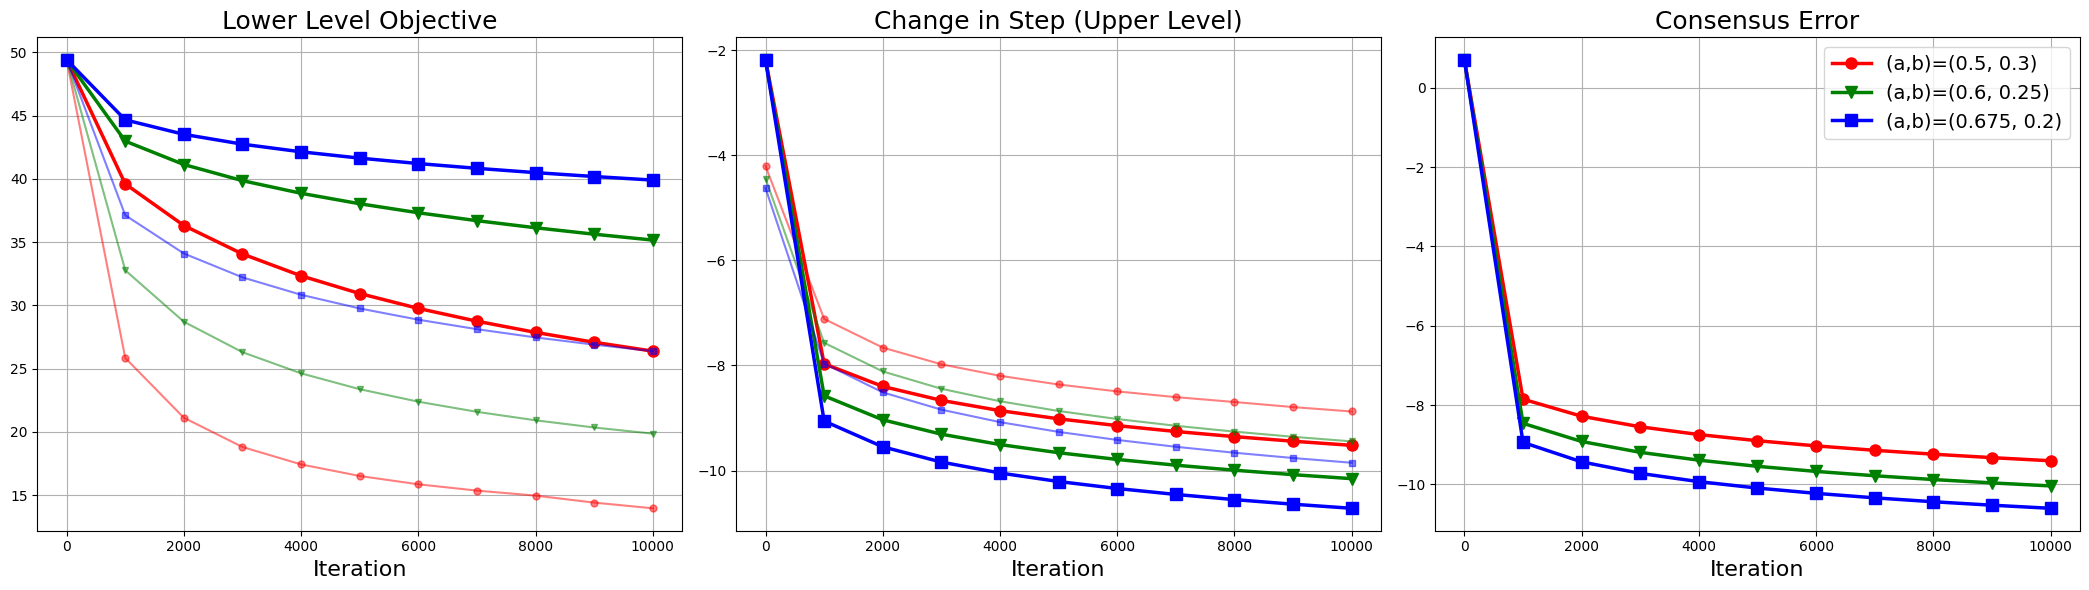

In [ ]:
# Combine the last three plots into a single row of subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# LOWER LEVEL OBJECTIVE
for key in a_b_params:
    axes[0].plot(x_ax, lower_vals_results[key], lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f'(a,b)={key}')
    axes[0].plot(x_ax, IRG_lower_vals_results[key], lw=1.5, marker=runmarker[key], markersize=5, color=runcolor[key], alpha=0.5)
axes[0].set_xlabel('Iteration', fontsize=16)
axes[0].set_title('Lower Level Objective', fontsize=18)
axes[0].grid(True)

# CHANGE IN STEP (UPPER LEVEL)
for key in a_b_params:
    axes[1].plot(x_ax, np.log(delta_x_vals_results[key]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
    axes[1].plot(x_ax, np.log(IRG_delta_x_vals_results[key]), lw=1.5, marker=runmarker[key], markersize=5, color=runcolor[key], alpha=0.5)
axes[1].set_xlabel('Iteration', fontsize=16)
axes[1].set_title('Change in Step (Upper Level)', fontsize=18)
axes[1].grid(True)

# CONSENSUS ERROR
for key in a_b_params:
    axes[2].plot(x_ax, np.log(consensus_vals_results[key]), lw=2.5, marker=runmarker[key], markersize=8, color=runcolor[key], label=f"(a,b)={key}")
    axes[2].plot(x_ax, np.log(IRG_consensus_vals_results[key]), lw=1.5, marker=runmarker[key], markersize=5, color=runcolor[key], alpha=0.5)
axes[2].set_xlabel('Iteration', fontsize=16)
axes[2].set_title('Consensus Error', fontsize=18)
axes[2].grid(True)
axes[2].legend(fontsize=14)

plt.tight_layout()
plt.show()


if save_plots:
    fig.savefig(f"./convexity-experiment/{path}/{reg_param}.pdf", dpi=600, format="pdf", pad_inches=0.01)